<a href="https://colab.research.google.com/github/MaxOng94/NLP-projects/blob/master/Machine_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd 
import numpy as np 
import re
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,LSTM, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
!wget https://github.com/MaxOng94/NLP-projects/blob/master/Machine_translation.zip?raw=true -O 'Machine_translation.zip'
!unzip "Machine_translation.zip"

--2020-09-29 10:30:30--  https://github.com/MaxOng94/NLP-projects/blob/master/Machine_translation.zip?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/MaxOng94/NLP-projects/raw/master/Machine_translation.zip [following]
--2020-09-29 10:30:30--  https://github.com/MaxOng94/NLP-projects/raw/master/Machine_translation.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MaxOng94/NLP-projects/master/Machine_translation.zip [following]
--2020-09-29 10:30:30--  https://raw.githubusercontent.com/MaxOng94/NLP-projects/master/Machine_translation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:

In [16]:
file_path = "Machine translation/fra-eng/fra.txt"

num_samples = 5000
eng_inputs = []
french_inputs= []
french_targets = []
#eng_chars = set()
#french_chars = set()
with open(file_path, 'r', encoding = 'utf-8') as f:
    data = f.readlines()
    for i in data[:num_samples]:
      # splitting the data into eng_inputs and french_targets
        input_text,target_text, _ = i.split('\t')
        # add a start of sentence tag for french inputs
        french_inputs_text = '<sos>' + target_text
        # Because french_outputs are shifted one timestep after, we add an end of sentence tag.
        french_targets_text= target_text + '<eos>'
        eng_inputs.append(input_text)
        french_inputs.append(french_inputs_text)
        french_targets.append(french_targets_text)



We will have two decoder data, one decoder_inputs (french_inputs) and one decoder_output (french_outputs). We are using teacher-forcing, a technique that uses the True output value (in this case, we have the french_outputs).

French_inputs will be one timestep earlier than french_outputs, so we tagged a eos tag for french_outputs and a sos tag for french_inputs.

Transform text to integers using Keras's tokenzier class



In [ ]:
max_num_words = 20000
tokenizer_encoder = Tokenizer(num_words = 20000)
tokenizer_encoder.fit_on_texts(eng_inputs)



In [ ]:
tokenizer_decoder = Tokenizer(num_words = 20000)
tokenizer_decoder.fit_on_texts(french_targets+ french_inputs)


In [ ]:
# to get the longest element in the eng_inputs list.
longest_element_in_eng_inputs= max(eng_inputs, key = len)
# to get the longest element in the french_targets list.
longest_element_in_french_targets= max(french_targets, key = len)

encoder_token_index = tokenizer_encoder.word_index 
decoder_token_index = tokenizer_decoder.word_index  

max_encoder_seq_length = len(longest_element_in_eng_inputs)
max_decoder_seq_length = len(longest_element_in_french_targets)
# vocab_size = len(word_index) + 1
encoder_vocab_size = len(encoder_token_index) +1
decoder_vocab_size = len(decoder_token_index) +1
latent_dim= 256

In [ ]:
print('Number of samples:', len(eng_inputs))
print('Number of unique encoder input vocab_size:', encoder_vocab_size)
print('Number of unique decoder output vocab_size:', decoder_vocab_size)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 5000
Number of unique encoder input vocab_size: 1265
Number of unique decoder output vocab_size: 2736
Max sequence length for inputs: 14
Max sequence length for outputs: 62


In [ ]:
# pad encoding inputs at the front
eng_inputs_integers = tokenizer_encoder.texts_to_sequences(eng_inputs)
encoder_input_data= pad_sequences(sequences = eng_inputs_integers, maxlen = max_encoder_seq_length)
print(encoder_input_data.shape)

(5000, 14)


In [ ]:
# pad decoding targets at the back
french_targets_integers = tokenizer_decoder.texts_to_sequences(french_targets)
decoder_target_data= pad_sequences(sequences = french_targets_integers, maxlen = max_decoder_seq_length,
                                   padding = 'post')
print(decoder_target_data.shape)

(5000, 62)


In [ ]:
# pad decoding inputs at the back
french_inputs_integers = tokenizer_decoder.texts_to_sequences(french_inputs)
decoder_input_data= pad_sequences(sequences = french_inputs_integers, maxlen = max_decoder_seq_length, 
                                  padding = 'post')
print(decoder_input_data.shape)

(5000, 62)


Generate data for decoding

In [ ]:
# one_hot_encode decoder target 
decoder_target_one_hot = np.zeros(
    (len(french_targets), max_decoder_seq_length ,decoder_vocab_size),
    dtype='float32')



In [ ]:
for i,d in enumerate(decoder_target_data):
  for t,word in enumerate(d):
    decoder_target_one_hot[i,t,word]= 1
    

We will use Glove's trained embedding matrix value as our weights for the embedding layer.
Our embedding matrix will have dimension 100, thus we select the 100 dimension glove weight matrix.

In [ ]:
embeddings_dictionary = dict()
glove_file = open(r"/content/drive/My Drive/Colab Notebooks/Dataset/glove.6B.100d.txt", encoding = 'utf-8')
for line in glove_file:
  records = line.split()
  word = records[0]
  vector_dimensions = np.array(records[1:], dtype='float32')
  embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = np.zeros((encoder_vocab_size, 100))

for word, index in encoder_token_index.items():
  embedding_vector = embeddings_dictionary.get(word)
  if embedding_vector is not None:
    embedding_matrix[index]= embedding_vector

In [ ]:
embedding_matrix.shape

(1265, 100)

In [ ]:
embedding_layer = Embedding(input_dim= encoder_vocab_size,output_dim=100, weights = [embedding_matrix],input_length = max_encoder_seq_length)

For this seq2seq problem, we will use an encoder-decoder architecture.

1) Encoder 
- We want to pass the hidden_state and cell_state of our LAST time step to the decoder.
- So we set return_state = True, where it returns the output, hidden_state and cell_state of the last time step.

2) Decoder will take the hidden state and cell state of the encoder as inputs.



Encoder 


In [ ]:
encoder_inputs = Input(shape = (max_encoder_seq_length,))
x = embedding_layer(encoder_inputs)
encoder_output,state_h,state_c = LSTM(latent_dim, return_state = True)(x)
encoder_states = [state_h, state_c]

Decoder

In [ ]:
decoder_inputs = Input(shape = (max_decoder_seq_length,))
decoder_embedding = Embedding(input_dim =decoder_vocab_size ,output_dim = latent_dim, input_length = max_decoder_seq_length)

decoder_inputs_x= decoder_embedding(decoder_inputs)

decoder_LSTM = LSTM(latent_dim, return_sequences = True, return_state = True)
# use initial_state = encoder_states. THis is important because decoder will now have the 
# context from encoding the english translation. 
decoder_outputs, _, _= decoder_LSTM(decoder_inputs_x,initial_state = encoder_states)

decoder_dense = Dense(decoder_vocab_size, activation = 'softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
model = Model([encoder_inputs, decoder_inputs],decoder_outputs)

In [ ]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

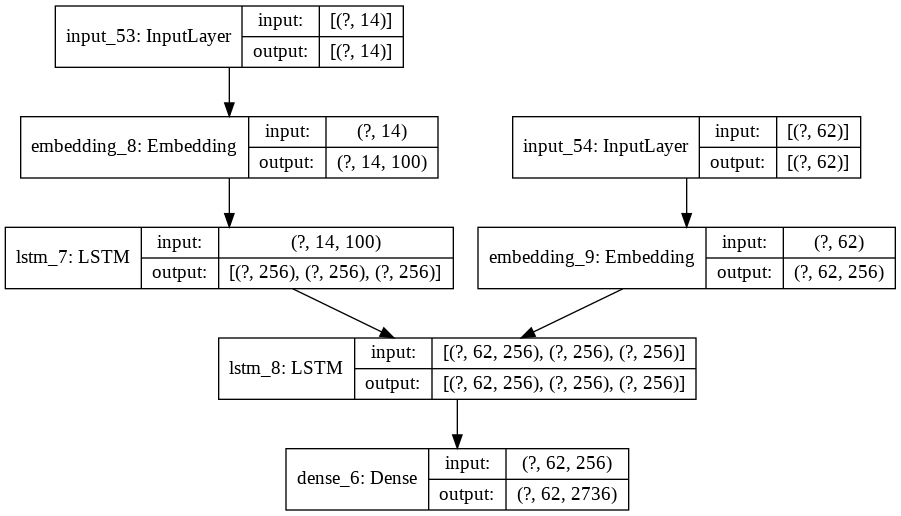

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
batch_size = 64
epochs =1

In [ ]:
model.fit([encoder_input_data, decoder_input_data], 
          decoder_target_one_hot,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

63/63 [==============================] - 79s 1s/step - loss: 0.7938 - accuracy: 0.9261 - val_loss: 0.3789 - val_accuracy: 0.9439


In [18]:
from tensorflow.keras.models import load_model

filepath_to_model = 'Machine translation/language_model.h5'
model = load_model(filepath_to_model)

Creating the prediction model

1) In the prediction model, we no longer are using teacher forcing. We are not using the true french translations at every time step, but we are instead using the previous's time step's output as inputs during the current time step.


*   This means that we have to modify the decoder's architect. 
*   Each time step will receive the previous time step's output and input, as well as the hidden and cell state of the previous time step. 

2) We will also need to modify the input shape for our embedding layer in our decoder. Since at each time step we are 


You will notice that during the creation of the model for prediction, we are reusing some of the layers that we ALREADY TRAINED in our training phase. 

Specifically, we re-use the 

1) Embedding layer in the previously trained decoder model

2) decoder_lstm layer in the previously trained decoder model 

3) decoder_dense layer in the previously trained decoder model




In [ ]:
model.summary()

Model: "functional_65"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           [(None, 14)]         0                                            
__________________________________________________________________________________________________
input_54 (InputLayer)           [(None, 62)]         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 14, 100)      126500      input_53[0][0]                   
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 62, 256)      700416      input_54[0][0]                   
______________________________________________________________________________________

In [ ]:
decoder_embedding_weights= model.get_layer(name = 'embedding_4').get_weights()[0]
decoder_embedding_weights.shape

(2736, 256)

In [ ]:
#1) Encode the eng_input we want to predict and get the initial decoder state 
#2) Run one step of the decoder using the initial state 
#3) Add a <sos> token at the start
#4) THe output of the decoder to be used as next target input 

encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
# the output of the encoder_model.predict() is the encoder_states to be used as initial decoder_state.

decoder_state_input_h = Input(shape = (latent_dim,))
decoder_state_input_c = Input(shape= (latent_dim,))
decoder_states_inputs = [decoder_state_input_h,decoder_state_input_c]

decoder_inputs_single = Input(shape= (1,))
# embedding layer reused from previous trained model 

#decoder_embedding = Embedding(input_dim =decoder_vocab_size ,output_dim = latent_dim, weights = [decoder_embedding_weights],
                              #input_length = 1)


decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# decoder_lstm is a reused layer from previous trained model
decoder_outputs, h,c = decoder_LSTM(decoder_inputs_single_x,initial_state = decoder_states_inputs)

decoder_states = [h,c]

# decoder_dense is a reused layer from previous training
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

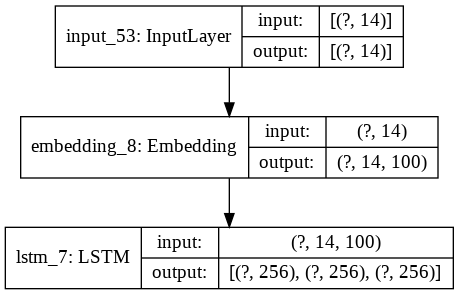

In [ ]:
plot_model(encoder_model,show_shapes = True, show_layer_names = True)

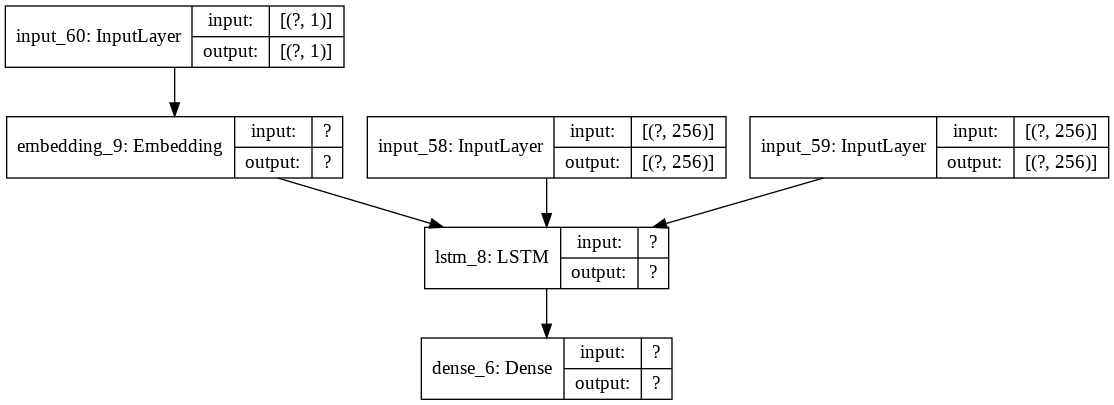

In [ ]:
plot_model(decoder_model,show_shapes = True, show_layer_names = True)

In [ ]:
encoder_index2word = {v:k for k, v in encoder_token_index.items()} # k is word, v is the index
decoder_index2word = {v:k for k, v in decoder_token_index.items()}

Translating the sentence 

In [ ]:
# input_seq should be sequence already, not text
def translate_sentence(input_seq):
  states = encoder_model.predict(input_seq)
  # our input will just be the <sos> sequence 
  decoder_seq = np.zeros((1,1))
  # get the sequence value for <sos> tag and use as input
  decoder_seq[0,0] = decoder_token_index.get('<sos>')
  eos = decoder_token_index.get('<eos>')
  output_sentence = []

  for i in range(max_decoder_seq_length):
    decoder_outputs, h,c = decoder_model.predict([decoder_seq]+ states)
     #to get the index position of the largest probability output, out of the 2736 unique french words 
     # find out what the shape of the output is
    idx = np.argmax(decoder_outputs[0,0,:]) 

    # if our predicted sequence is the same as the sequence of eos tag, break the loop
    if eos == idx:
      break 

    word = ''  

    word = decoder_index2word[idx]
    output_sentence.append(word)

    decoder_seq = idx
    states = [h,c]  
  return ' '.join(output_sentence)

In [ ]:
encoder_input_data[0:1].shape

(1, 14)

In [ ]:
#i = np.random.choice(len(eng_inputs))
input_seq = encoder_input_data[1:2] # so the shape will be 2d (1,14)
translation = translate_sentence(input_seq)
print("input",eng_inputs[1])
print("translation", translation)

InvalidArgumentError: ignored